<a href="https://colab.research.google.com/github/bejr1833/mini-project-batch_9/blob/main/mini_final_vit_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install torch torchvision transformers


  Using cached nvidia_cuda_nvrtc_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-9.1.0.70-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.4.5.8-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.2.1.3-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.5.147-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.6.1.9-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.3.1.170-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nvjitlink_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, random_split
from PIL import Image
from transformers import ViTForImageClassification
import os


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define dataset path in Google Drive
dataset_path = "/content/drive/MyDrive/archive (1) - Copy/dataset"

# Define hyperparameters
batch_size = 16
learning_rate = 2e-5
num_epochs = 5
num_classes = 4  # ["Normal", "Glaucoma", "Diabetic Retinopathy", "Cataract"]


In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])


In [ ]:
# Load dataset
dataset = datasets.ImageFolder(root=dataset_path, transform=transform)

# Split dataset into training (80%) and validation (20%)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Print class labels
class_labels = dataset.classes  # ["Normal", "Glaucoma", "Diabetic Retinopathy", "Cataract"]
print("Class Labels:", class_labels)


Class Labels: ['cataract', 'diabetic_retinopathy', 'glaucoma', 'normal']


In [ ]:
model = ViTForImageClassification.from_pretrained("google/vit-base-patch16-224",
                                                      num_labels=num_classes,
                                                      ignore_mismatched_sizes=True)
model.to(device)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([4]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([4, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=768, out_features=3072, bias=True)
            (intermed

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=learning_rate)


In [ ]:
def train_model(model, train_loader, val_loader, epochs=5):
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)  # Ensure data is on the same device
            optimizer.zero_grad()

            outputs = model(images).logits  # Get predictions
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_acc = 100 * correct / total
        val_acc = evaluate_model(model, val_loader)

        print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader):.4f}, Train Acc: {train_acc:.2f}%, Val Acc: {val_acc:.2f}%")

def evaluate_model(model, loader):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)  # Move to GPU
            outputs = model(images).logits
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return 100 * correct / total

# Train the model
train_model(model, train_loader, val_loader, num_epochs)


Epoch 1/5, Loss: 0.4522, Train Acc: 83.68%, Val Acc: 90.92%
Epoch 2/5, Loss: 0.1671, Train Acc: 94.25%, Val Acc: 91.51%
Epoch 3/5, Loss: 0.0792, Train Acc: 97.46%, Val Acc: 91.63%
Epoch 4/5, Loss: 0.0293, Train Acc: 99.14%, Val Acc: 92.57%
Epoch 5/5, Loss: 0.0240, Train Acc: 99.11%, Val Acc: 91.75%


In [ ]:
torch.save(model.state_dict(), "eye_disease_vit.pth")
print("Model saved successfully!")


Model saved successfully!


In [ ]:
# Load Model
model = ViTForImageClassification.from_pretrained(
    "google/vit-base-patch16-224",
    num_labels=num_classes, # This needs to match the num_classes from training
    ignore_mismatched_sizes=True # This will ignore the size mismatch if any
)
model.load_state_dict(torch.load("eye_disease_vit.pth", map_location=device))
model.to(device)
model.eval()

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([4]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([4, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=768, out_features=3072, bias=True)
            (intermed

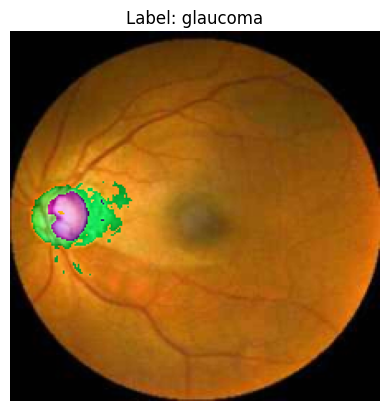

In [ ]:
import os
import random
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd

def display_random_image(dataset, classes): # Pass classes as an argument
    """
    Displays a random image from the dataset.

    Args:
        dataset: A PyTorch dataset object.
        classes: A list of class names. # Add classes argument
    """

    # Get a random index
    random_index = random.randint(0, len(dataset) - 1)

    # Get the image and label at that index
    image, label = dataset[random_index]

    # Convert the image to a PIL Image
    image = transforms.ToPILImage()(image)

    # Display the image
    plt.imshow(image)
    plt.title(f'Label: {classes[label]}') # Access classes using the argument
    plt.axis('off')
    plt.show()

# Call the function with your train_dataset and dataset.classes
display_random_image(train_dataset, dataset.classes) # Pass dataset.classes

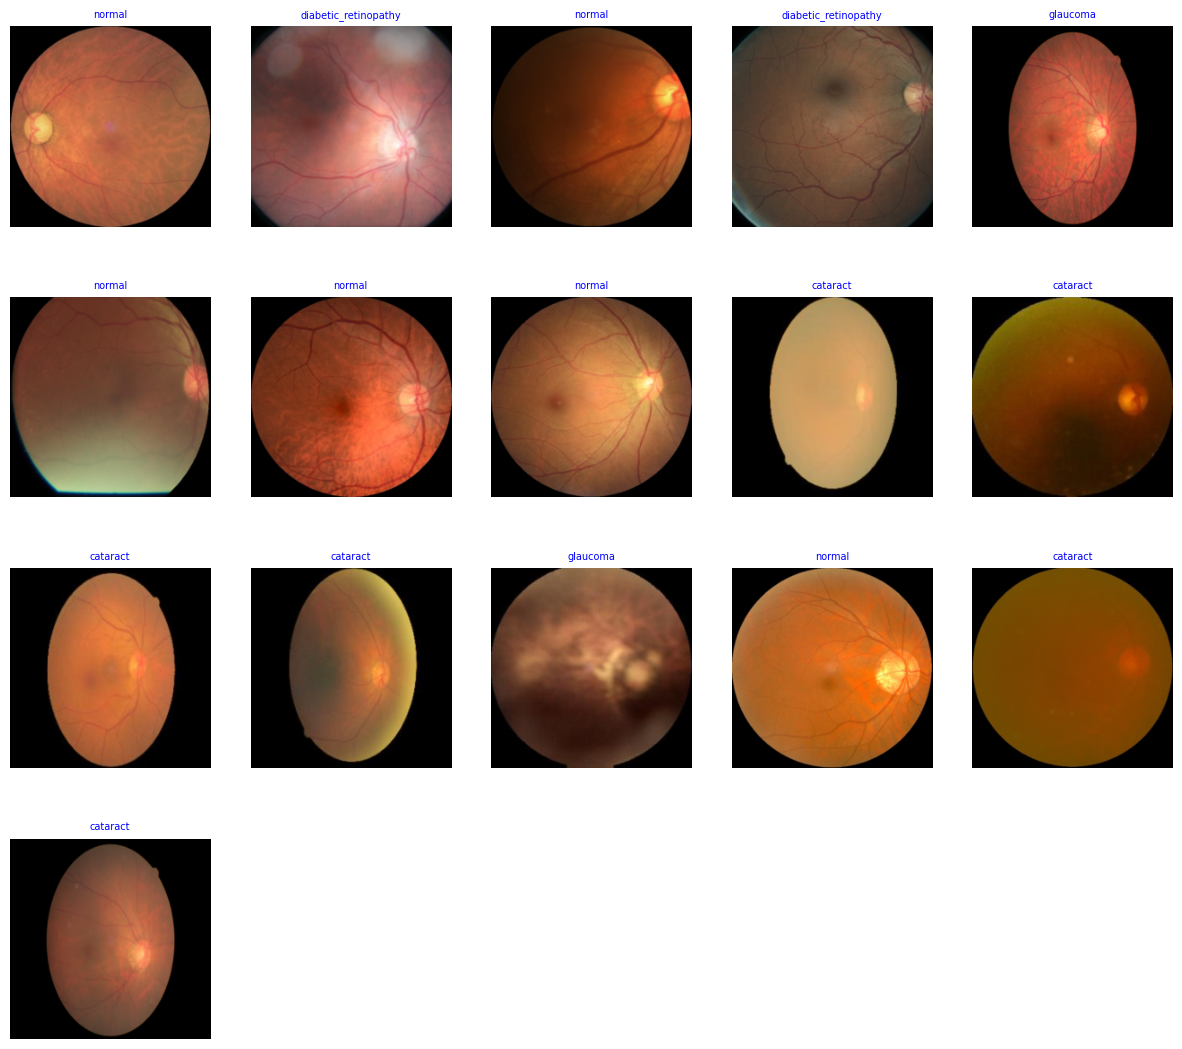

In [ ]:
import numpy as np
def show_images(gen, classes): # Pass classes as an argument
    images, labels = next(gen)        # get a batch size samples from the generator
    length = len(labels)
    sample = min(length, 20)
    plt.figure(figsize= (15, 17))
    for i in range(sample):
        plt.subplot(5, 5, i + 1)
        image = images[i] / 2 + 0.5      # Un-normalize the image
        image = image.numpy().transpose(1, 2, 0) # change the order of the axes from (C, H, W) to (H, W, C)
        plt.imshow(image)
        class_name = classes[labels[i].item()] # Access classes using the labels and classes argument
        plt.title(class_name, color= 'blue', fontsize= 7 )
        plt.axis('off')
    plt.show()

# Assuming 'train_loader' is your DataLoader for augmented training data
# Replace 'train_loader' with the actual name of your augmented data loader
show_images(iter(train_loader), dataset.classes) # Pass dataset.classes

In [ ]:
def identify_disease(image_path):
    """
    Identifies the eye disease in an image.

    Args:
        image_path (str): Path to the image.

    Returns:
        str: Predicted disease label.
    """
    image = Image.open(image_path).convert("RGB")  # Ensure it's RGB
    image = transform(image).unsqueeze(0).to(device)  # Apply transformations and move to GPU

    with torch.no_grad():
        outputs = model(image).logits
        _, predicted = torch.max(outputs, 1)

    return class_labels[predicted.item()]  # Return class name

# Example Usage
image_path = "/content/drive/MyDrive/archive (1) - Copy/dataset/cataract/0_left.jpg"  # Change this
predicted_disease = identify_disease(image_path)
print(f"Predicted Eye Disease: {predicted_disease}")


Predicted Eye Disease: cataract


In [ ]:
!pip install scikit-learn


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report
import numpy as np

def evaluate_model(model, loader):
    model.eval()
    all_labels = []
    all_preds = []
    all_probs = []

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)  # Ensure the data is on the same device

            # Get model outputs
            outputs = model(images).logits

            # Get predicted labels and probabilities
            _, predicted = torch.max(outputs, 1)
            probabilities = torch.nn.functional.softmax(outputs, dim=1)  # Convert logits to probabilities

            # Store the predictions and true labels
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())
            all_probs.extend(probabilities.cpu().numpy())

    # Convert lists to numpy arrays for metric calculations
    all_labels = np.array(all_labels)
    all_preds = np.array(all_preds)
    all_probs = np.array(all_probs)

    # Calculate metrics
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='weighted', zero_division=1)
    recall = recall_score(all_labels, all_preds, average='weighted', zero_division=1)
    f1 = f1_score(all_labels, all_preds, average='weighted')

    # For AUC, we need to calculate it for each class
    auc = roc_auc_score(all_labels, all_probs, multi_class='ovr', average='weighted')

    # Print classification report for detailed metrics per class
    print("\nClassification Report:\n", classification_report(all_labels, all_preds, target_names=class_labels))

    return accuracy, precision, recall, f1, auc

# Example Usage: Evaluate on the validation set
accuracy, precision, recall, f1, auc = evaluate_model(model, val_loader)
print(f"\nAccuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"AUC Score: {auc:.4f}")



Classification Report:
                       precision    recall  f1-score   support

            cataract       0.94      0.89      0.92       208
diabetic_retinopathy       1.00      1.00      1.00       225
            glaucoma       0.91      0.83      0.87       210
              normal       0.83      0.94      0.88       205

            accuracy                           0.92       848
           macro avg       0.92      0.92      0.92       848
        weighted avg       0.92      0.92      0.92       848


Accuracy: 0.9175
Precision: 0.9204
Recall: 0.9175
F1 Score: 0.9175
AUC Score: 0.9887


In [ ]:
accuracy, precision, recall, f1, auc = evaluate_model(model, val_loader)



Classification Report:
                       precision    recall  f1-score   support

            cataract       0.94      0.89      0.92       208
diabetic_retinopathy       1.00      1.00      1.00       225
            glaucoma       0.91      0.83      0.87       210
              normal       0.83      0.94      0.88       205

            accuracy                           0.92       848
           macro avg       0.92      0.92      0.92       848
        weighted avg       0.92      0.92      0.92       848

